In [1]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from matplotlib.pylab import plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


import seaborn as sns
import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from loguru import logger
import pycountry

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import SCORERS, median_absolute_error

from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

# Load Dataset

## The cases and hospitalisation numbers by age group

In [2]:
# https://data.gov.ie/dataset/covidstatisticsprofilehpscirelandopendata
CovidStatisticsProfileHPSCIrelandOpenData = 'http://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}'

df = pd.read_csv(CovidStatisticsProfileHPSCIrelandOpenData, parse_dates=['Date'])
df.shape, df.columns, df['Date'].max()

((176, 38),
 Index(['X', 'Y', 'Date', 'ConfirmedCovidCases', 'TotalConfirmedCovidCases',
        'ConfirmedCovidDeaths', 'TotalCovidDeaths', 'StatisticsProfileDate',
        'CovidCasesConfirmed', 'HospitalisedCovidCases',
        'RequiringICUCovidCases', 'HealthcareWorkersCovidCases',
        'ClustersNotified', 'HospitalisedAged5', 'HospitalisedAged5to14',
        'HospitalisedAged15to24', 'HospitalisedAged25to34',
        'HospitalisedAged35to44', 'HospitalisedAged45to54',
        'HospitalisedAged55to64', 'HospitalisedAged65up', 'Male', 'Female',
        'Unknown', 'Aged1', 'Aged1to4', 'Aged5to14', 'Aged15to24', 'Aged25to34',
        'Aged35to44', 'Aged45to54', 'Aged55to64', 'Aged65up', 'Median_Age',
        'CommunityTransmission', 'CloseContact', 'TravelAbroad', 'FID'],
       dtype='object'),
 Timestamp('2020-08-24 00:00:00+0000', tz='UTC'))

### Fix reporting issues due to negatives
It looks like there are a couple of obvious problems, especially with the 65up category; looks like this only impacts the cases not the hospital numbers although there are some other issues with the latter. Let's drop these out.

6619.0

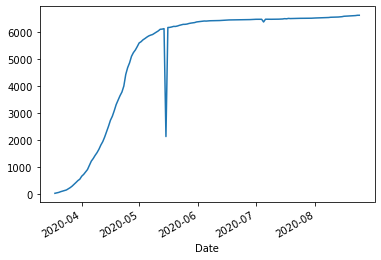

In [3]:
df.set_index('Date')['Aged65up'].plot()
df['Aged65up'].max()

In [4]:
# Drop negative entires and replace with the next days count (or the day after that if necessary)

case_age_cols = df.filter(regex='^Age').columns

diffs = df[case_age_cols].diff()
df[case_age_cols] = df[case_age_cols][diffs>=0].fillna(df[case_age_cols][diffs>=0].shift(1)).fillna(df[case_age_cols][diffs>=0].shift(2))

df.set_index('Date')[case_age_groups].diff().rolling(7).mean().plot()

df[df[case_age_cols]<0][case_age_cols].dropna()

NameError: name 'case_age_groups' is not defined

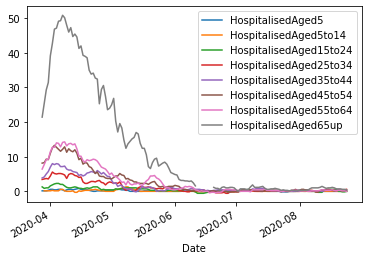

In [5]:
# Not the dip in the 65up group below.
# Looks like numbers were restated downwards.

hospital_age_cols = df.filter(regex='^HospitalisedAge').columns

diffs = df[hospital_age_cols].diff()
df[hospital_age_cols] = df[hospital_age_cols][diffs>=0].fillna(df[hospital_age_cols][diffs>=0].shift(1)).fillna(df[hospital_age_cols][diffs>=0].shift(2))

df.set_index('Date')[hospital_age_cols].diff().rolling(7).mean().plot()

## Manual CFRs
From epidmiology reports at https://www.hpsc.ie/a-z/respiratory/coronavirus/novelcoronavirus/casesinireland/epidemiologyofcovid-19inireland/

In [8]:
import tabula
file = 'https://www.hpsc.ie/a-z/respiratory/coronavirus/novelcoronavirus/casesinireland/epidemiologyofcovid-19inireland/COVID-19_Daily_epidemiology_report_(NPHET)_Website.pdf'

tables = tabula.read_pdf(file, pages = "all", multiple_tables = True)

Got stderr: Aug 24, 2020 7:10:17 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider loadDiskCache
Aug 24, 2020 7:10:17 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Aug 24, 2020 7:10:21 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Aug 24, 2020 7:10:22 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font Arial are not implemented in PDFBox and will be ignored
Aug 24, 2020 7:10:22 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font Arial are not implemented in PDFBox and will be ignored
Aug 24, 2020 7:10:22 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font Arial are not implemented in PDFBox and will be ignored



In [17]:
tables[6].dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unknow
3,cases (n),257,480,"2,329","4,812","4,873","4,883","3,416","1,894","2,324","2,386",21
5,hospitalised (n),24,18,80,204,279,456,503,595,753,480,1
8,(%),9.34,3.75,3.43,4.24,5.73,9.34,14.72,31.41,32.4,20.12,4.76
11,ICU (n),0,2,5,15,37,92,128,110,48,6,0
14,ICU (%),0,0.42,0.21,0.31,0.76,1.88,3.75,5.81,2.07,0.25,0
15,Deaths (n),0,0,1,5,12,24,68,227,521,660,0
17,ratio (%),0,0,0.04,0.1,0.25,0.49,1.99,11.99,22.42,27.66,0


In [630]:
cfr = pd.read_csv('../data/cfr.csv', delimiter='\t').set_index('date')
cfr

,Aged5,Aged5to14,Aged15to24,Aged25to34,Aged35to44,Aged45to54,Aged55to64,Aged65up
date,,,,,,,,
01/04/2020,0,0,0.000000,0.001927,0.001818,0.001792,0.013636,0.111441
01/05/2020,0,0,0.001467,0.001223,0.002578,0.005330,0.016999,0.170122
01/06/2020,0,0,0.001093,0.001191,0.002273,0.005125,0.018414,0.202351
01/07/2020,0,0,0.000527,0.001169,0.002453,0.005031,0.019379,0.212365
01/08/2020,0,0,0.000491,0.001118,0.002607,0.005138,0.020328,0.214067


## Ages Census Data

In [589]:
ages = pd.read_csv('../data/ages_ireland_2016.csv')
ages['total'] = ages['M']+ages['F']
ages.head()

,age,M,F,total
0,0,31876,30381,62257
1,1,32824,31205,64029
2,2,34031,32287,66318
3,3,34785,33291,68076
4,4,36215,34620,70835


# Share of Cases & Hospitalisations by Age Group

In [590]:
case_age_cols, hospital_age_cols

(Index(['Aged1', 'Aged1to4', 'Aged5to14', 'Aged15to24', 'Aged25to34',
        'Aged35to44', 'Aged45to54', 'Aged55to64', 'Aged65up'],
       dtype='object'),
 Index(['HospitalisedAged5', 'HospitalisedAged5to14', 'HospitalisedAged15to24',
        'HospitalisedAged25to34', 'HospitalisedAged35to44',
        'HospitalisedAged45to54', 'HospitalisedAged55to64',
        'HospitalisedAged65up'],
       dtype='object'))

## Align cases/hospital age groups

In [592]:
case_age_cols = [col.replace('Hospitalised', '') for col in hospital_age_cols[1:]]

df['Aged5'] = df['Aged1']+df['Aged1to4']

case_age_cols

['Aged5to14',
 'Aged15to24',
 'Aged25to34',
 'Aged35to44',
 'Aged45to54',
 'Aged55to64',
 'Aged65up']

## Total/Share of 14d cases by age group

In [593]:
july_1 = datetime(2020, 4, 1)

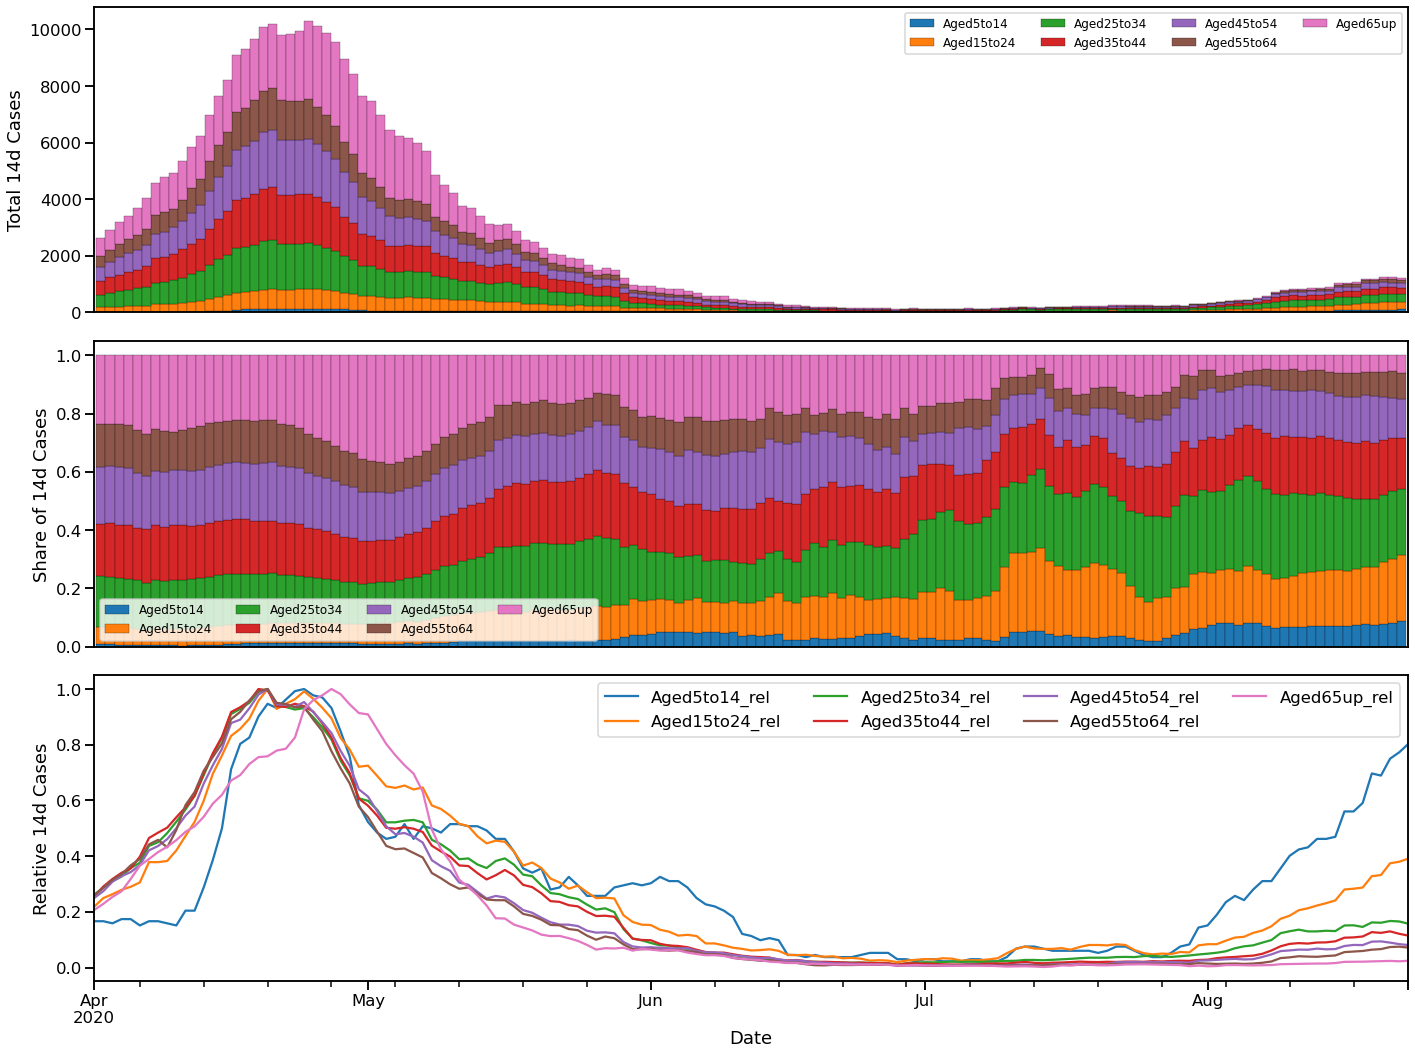

In [618]:
sns.set_context('talk')

fig, (ax, bx, cx) = plt.subplots(figsize=(20, 15), nrows=3, sharex=False)

cases_by_age_14d_totals = df.set_index('Date')[case_age_cols].diff().rolling('14d').sum()
cases_by_age_14d_totals.dropna().loc[july_1:].plot(kind='bar', stacked=True, ax=ax, width=1, edgecolor='k', lw=.25)


cases_by_age_14d_share = cases_by_age_14d_totals.div(cases_by_age_14d_totals.sum(axis=1), axis=0)
cases_by_age_14d_share.dropna().loc[july_1:].plot(kind='bar', stacked=True, ax=bx, width=1, edgecolor='k', lw=.25)


# bx.set_xticks(np.arange(0, len(cases_by_age_14d_share.dropna().loc[july_1:]), 7))
# bx.set_xticklabels(cases_by_age_14d_share.dropna().loc[july_1:].iloc[np.arange(0, len(cases_by_age_14d_share.dropna().loc[july_1:]), 7)].reset_index()['Date'].map(lambda dt: datetime.strftime(dt, '%b %d')), rotation=0)


rel_cases_by_age_14d_totals = pd.concat([cases_by_age_14d_totals[case_age_col]/cases_by_age_14d_totals[case_age_col].max() for case_age_col in cases_by_age_14d_totals.columns], axis=1).add_suffix('_rel')
rel_cases_by_age_14d_totals.dropna().loc[july_1:].plot(ax=cx)


ax.legend(loc='upper right', ncol=4, fontsize=12)
bx.legend(loc='lower left', ncol=4, fontsize=12)
cx.legend(ncol=4, loc='upper right')


ax.set_ylabel('Total 14d Cases')
bx.set_ylabel('Share of 14d Cases')
cx.set_ylabel('Relative 14d Cases')

ax.set_xlabel('')
bx.set_xlabel('')
ax.set_xticks([])
bx.set_xticks([])
ax.set_xticklabels([])
bx.set_xticklabels([])


fig.tight_layout()

## Total/Share of 14d hospitalisations by age group

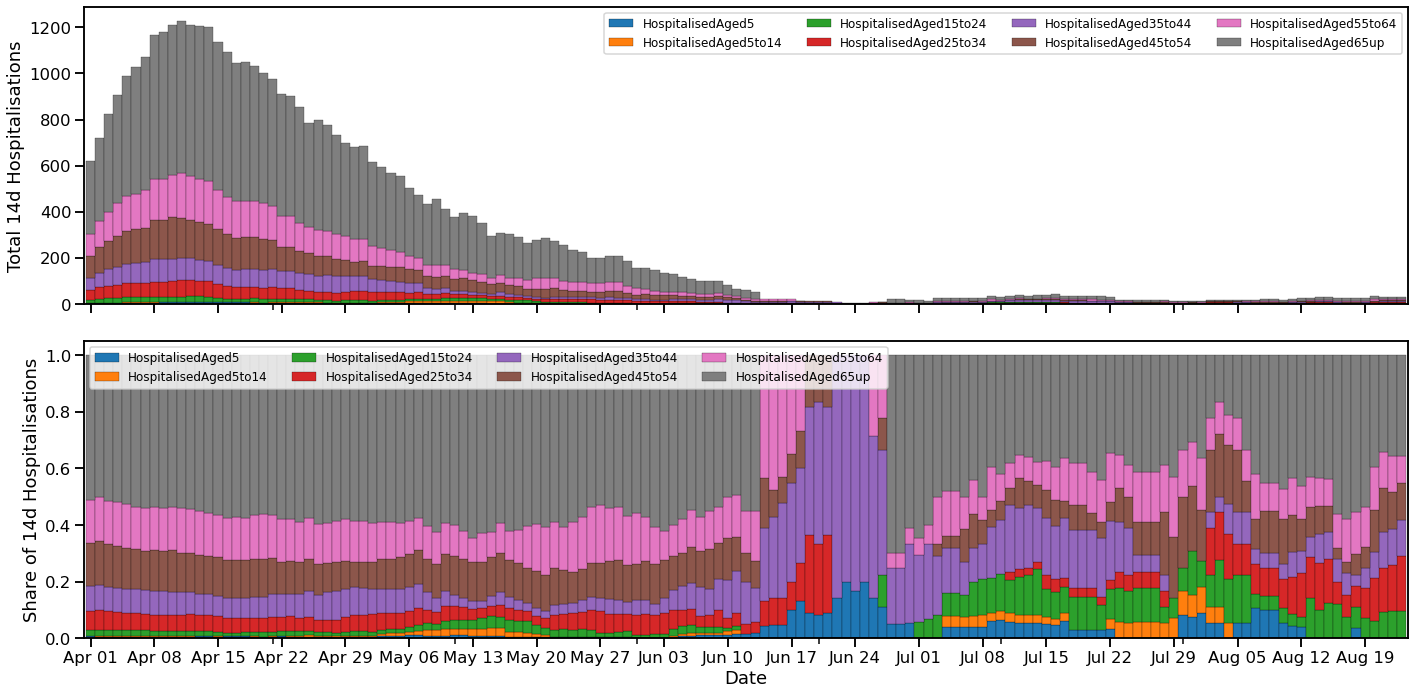

In [539]:
fig, (ax, bx) = plt.subplots(figsize=(20, 10), nrows=2, sharex=True)

hospital_by_age_14d_totals = df.set_index('Date')[hospital_age_groups].diff().rolling('14d').sum().clip(lower=0)
hospital_by_age_14d_totals.dropna().loc[july_1:].plot(kind='bar', stacked=True, ax=ax, width=1, edgecolor='k', lw=.25)


hospital_by_age_14d_share = hospital_by_age_14d_totals.div(hospital_by_age_14d_totals.sum(axis=1), axis=0)
hospital_by_age_14d_share.dropna().loc[july_1:].plot(kind='bar', stacked=True, ax=bx, width=1, edgecolor='k', lw=.25)


ax.legend(loc='upper right', ncol=4, fontsize=12)
bx.legend(loc='upper left', ncol=4, fontsize=12)


bx.set_xticks(np.arange(0, len(hospital_by_age_14d_share.dropna().loc[july_1:]), 7))
bx.set_xticklabels(hospital_by_age_14d_share.dropna().loc[july_1:].iloc[np.arange(0, len(hospital_by_age_14d_share.dropna().loc[july_1:]), 7)].reset_index()['Date'].map(lambda dt: datetime.strftime(dt, '%b %d')), rotation=0)

ax.set_ylabel('Total 14d Hospitalisations')
bx.set_ylabel('Share of 14d Hospitalisations')




fig.tight_layout()



